In [1]:
%matplotlib inline

import numpy as np
import clean_src as src
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.integrate import odeint

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


[[ 0.08356295  0.08542805  0.01065359  0.01271292]
 [ 0.08542805  0.08733519  0.01084588  0.01294276]
 [ 0.01065359  0.01084588  0.0625216   0.07246374]
 [ 0.01271292  0.01294276  0.07246374  0.08400589]]


#### ODE Model specification 

We are going to consider a model of the form
$$
    \dot{\mathbf{X}} = \mathbf{A}(t)\mathbf{X} + \mathbf{f}(t)
$$

In [2]:
def A(x, t):
    return np.array([[-t, 1.],
                     [ 0., -0.1*t**2]])

def dXdt(X, t):
    return np.dot(A(X,t),X)

# Initial conditions
x0 = np.array([1., 0.])
t0 = 0.

odeModel = src.ODE(initTime=t0, initCond=x0,
                   dXdt=dXdt, dXdt_xJac=A, isLinear=True)


#### Data simulation 

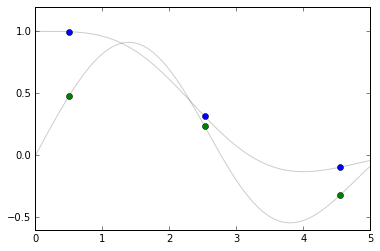

In [3]:
def b(t):
    return np.array([0., np.cos(t)]) 

def dYdt(Y,t):
    return dXdt(Y,t) + b(t)

tt = np.linspace(t0, 5., 100)
sol = odeint(dYdt, x0, tt)

redInd = np.linspace(10, tt.size-10, 3, dtype=np.intp)
Data = np.column_stack((tt[redInd], sol[redInd,:]))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, sol, 'k-', alpha=0.2)
ax.plot(Data[:,0], Data[:,1:], 'o')
plt.show()

#### Initalise the GPODE model

This requires specifying a sequence of knots points $\tau_0, \ldots, \tau_n$ such that the time dependent function $\mathbf{A}(t)$ is assumed to be constant on each interval, that is to say

$$
\begin{align*}
    \mathbf{A}(t) = \mathbf{A}((\tau_i + \tau_{i+1})/2 ) \qquad \mbox{if } t \in [\tau_i, \tau_{i+1} ).
\end{align*}
$$

In [4]:
tknots = np.linspace(0., 5., 15)

gpode = src.tvODE(tknots, odeModel, 2)
gpode.setup_time_vec(Data[:,0])

att = gpode.get_Atk()

lScales = np.array([1., 0.5])
cScales = np.array([0., 1.])

In [5]:
cov = gpode.get_cov(cScales, lScales, Data[:,0])
mean = odeModel.solve(Data[:,0])

L = np.linalg.cholesky(cov)
La = np.linalg.solve(L.T, np.linalg.solve(L, Data[:,1:].ravel() - mean.ravel()))

def pred(t):
    k = gpode.get_kvec(t, cScales, lScales)

    k11 = k[:, :gpode.dim]
    k12 = k[:, gpode.dim:]
    
    m = gpode.mean(t)
    
    expr = np.linalg.solve(L.T, np.linalg.solve(L, k12.T))
    var = k11 - np.dot(k12, expr)
    
    return np.concatenate((m + np.dot(k12, La), np.diag(var)))
    
ss = np.linspace(0.1, Data[-1,0], 50)

predVal = np.array([pred(s) for s in ss])
ss = np.concatenate(( [t0] , ss ))

predVal = np.row_stack(( np.concatenate((x0, np.zeros(2))),
                         predVal))

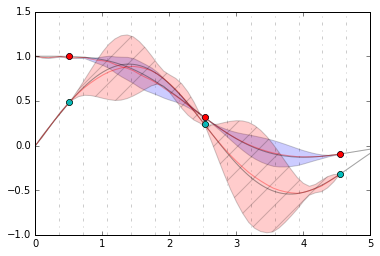

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, sol, 'k-', alpha=0.2)
ax.plot(Data[:,0], Data[:,1:], 'o')
ax.plot(ss, predVal[:,:2], 'r-', alpha=0.2)

with np.errstate(invalid='ignore'):
    sdx = np.sqrt(predVal[:,2])
    sdx[np.isnan(sdx)] = 0.
    sdy = np.sqrt(predVal[:,3])
    sdy[np.isnan(sdy)] = 0.

ax.fill_between(ss, 
                predVal[:,0] + 2*sdx, 
                predVal[:,0] - 2*sdx, alpha=0.2, facecolor='blue')

ax.fill_between(ss, 
                predVal[:,1] + 2*sdy, 
                predVal[:,1] - 2*sdy, 
                alpha=0.2, facecolor='red', hatch='/')

for tk in tknots:
    ax.plot( [tk, tk], [-1., 1.5], 'k-.', alpha=0.2)

ax.plot(tt, sol, 'k-', alpha=0.2)
ax.plot(Data[:,0], Data[:,1:], 'o')
ax.plot(ss, predVal[:,:2], 'r-', alpha=0.2)
    
plt.show()

[ 1.  0.]


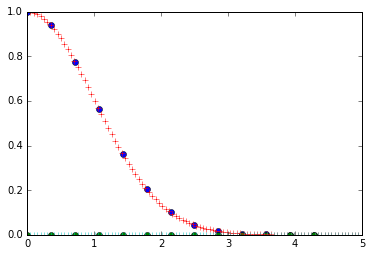

In [7]:
print gpode.mean(0.)
ms = np.array([gpode.mean(t) for t in tt])

sol0 = odeint(dXdt, x0, tt)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpode.ttk, gpode.storedMeans, 'o')
ax.plot(tt, sol0, '+')
